# Minimal promoter MPRA analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')
import polars as pl
import polars.selectors as cs
import plotly.express as px
import plotly.io as pio
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import pandas as pd
from Bio import SeqIO
from scipy import stats
pl.Config.set_fmt_str_lengths(50)
sns.set_style(style='whitegrid')
warnings.filterwarnings('ignore')
import Levenshtein

## Reading and formatting input

In [2]:
cd = "/data/cephfs-2/unmirrored/groups/kircher/MPRA/CaptureCMPRA/"
minp = pl.read_csv(cd + 'results/CMPRA5_minP/BCalm/minP_logfcs.tsv.gz', separator='\t')
cmpra = pl.read_csv(cd + "results/MPRA_analysis/CMPRA5/labeled_data_promoteroa_OA.tsv", separator="\t")
fig_dir = "/data/cephfs-2/unmirrored/groups/kircher/MPRA/CaptureCMPRA/results/manuscript_figures/minP/"

In [3]:
minp_tested = minp.filter(pl.col("label") == "test").with_columns(pl.col("oligo_name").str.replace(":", "-")).select(
	minp_logFC = pl.col("logFC"),
	minp_padj = pl.col("adj.P.Val"),
	name = pl.col("oligo_name")
)
minp_tested = minp_tested.with_columns(name = pl.col("name").add("-."))

In [4]:
minp.group_by("label").count()

label,count
str,u32
"""shuffled""",199
"""positive""",60
"""test""",14937
"""negative""",87


In [5]:
cmpra = cmpra.with_columns(
	pl.when(pl.col("OE") == pl.col("left_bin")).then(pl.col("screen_left")).when(
		pl.col("OE") == pl.col("right_bin")).then(pl.col("screen_right")).otherwise(None).alias("OE_screen_label"),
	)


In [6]:
left_enh = cmpra.join(minp_tested, left_on="left_bin", right_on="name").select("logFC", "minp_logFC", "adj.P.Val", "minp_padj"
, "left_bin", "right_bin", "label", "OE_screen_label").with_columns(OE=pl.col("left_bin"), promoter=pl.col("right_bin"))
right_enh = cmpra.join(minp_tested, left_on="right_bin", right_on="name").select("logFC", "minp_logFC", "adj.P.Val", "minp_padj"
, "left_bin", "right_bin", "label", "OE_screen_label").with_columns(OE=pl.col("right_bin"), promoter=pl.col("left_bin"))

In [7]:
left_enh.height

3997

In [8]:
# Remove bin columns, we now renamed them to OE and promoter
df = pl.concat([left_enh, right_enh]).select(~cs.matches("bin"))

# Select only those interacting with a targeted promoter
df = df.filter(pl.col("label") != "other - other")

In [9]:
print(df.height)
df = df.filter((pl.col("OE_screen_label").str.contains("PLS").not_()) | (pl.col("OE_screen_label").is_null()))
print(df.height)

6198
6198


## Defining functions


In [10]:
def ridge_plot(data, x, y, order=None, title=None):
	pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
	g = sns.FacetGrid(data.to_pandas(), row=y, hue=y, aspect=8, height=0.8, palette=pal, row_order=order)#, xlim=(-2.2, 2.5))

	# Draw the densities in a few steps
	g.map(sns.kdeplot, x, 
		bw_adjust=.5, clip_on=True,
		fill=True, alpha=1, linewidth=1.5)
	g.map(sns.kdeplot, x, clip_on=False, color="w", lw=2, bw_adjust=.5)

	# passing color=None to refline() uses the hue mapping
	g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

	def label(x, color, label):
		ax = plt.gca()
		ax.text(-0.1, .2, label, fontweight="bold", color=color,fontsize=13,
				ha="left", va="center", transform=ax.transAxes)


	g.map(label, x)

	g.figure.subplots_adjust(hspace=-.5)
	g.figure.suptitle(title) #, fontsize=20)

	g.set_titles("")
	g.set(yticks=[], ylabel="")
	#g.set(xlim=(-2.2, 2.5))
	g.despine(bottom=True, left=True)

## Filtering nearby interactions

In [11]:
# Selecting interactions <= 2MB away
coords = df.with_columns(
	OE__chr = pl.col("OE").str.extract(r"chr(\d+)"),
	OE__st = pl.col("OE").str.split("-").list.get(1).cast(pl.Int32),
	OE__end = pl.col("OE").str.split("-").list.get(2).cast(pl.Int32),
	promoter__chr = pl.col("promoter").str.extract(r"chr(\d+)"),
	promoter__st = pl.col("promoter").str.split("-").list.get(1).cast(pl.Int32),
	promoter__end = pl.col("promoter").str.split("-").list.get(2).cast(pl.Int32)
)
df_filt = coords.filter(
	pl.col("OE__chr") == pl.col("promoter__chr")
				   ).with_columns( dist =
	np.abs((pl.col("OE__end") + pl.col("OE__st"))/2 - (pl.col("promoter__end") + pl.col("promoter__st"))/2),
	prom_length = pl.col("promoter__end") - pl.col("promoter__st"),
	OE_length = pl.col("OE__end") - pl.col("OE__st"))
#df_filt = df_filt.filter(pl.col("dist") <= 2000000) #.filter(pl.col("prom_length") >= 50).filter(pl.col("OE_length") >= 50)
prom_coords = df_filt.select("promoter__chr", "promoter__st", "promoter__end").unique()
df_filt = df_filt.select(~cs.matches("__"))


In [12]:
prom_coords.with_columns(promoter__chr = "chr" + pl.col("promoter__chr")).write_csv("promoter_coords.bed", separator="\t")

<Axes: >

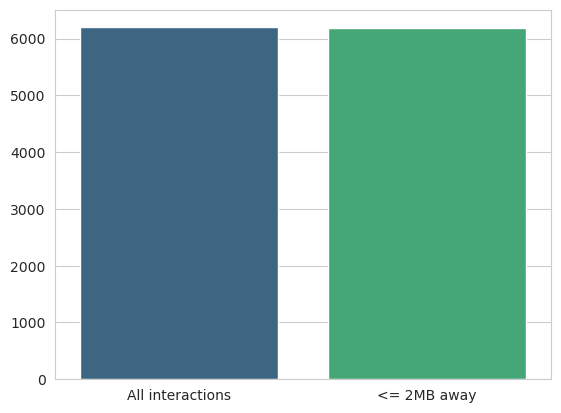

In [13]:
# plot number of nearby interactions vs all interactions as a barplot
sns.barplot(y=[df.height, df_filt.height], x=["All interactions", "<= 2MB away"], palette="viridis")

In [14]:
df_unfilt = df
df = df_filt
print(df_unfilt.height, df.height)

6198 6186


## Ridge plot of activity

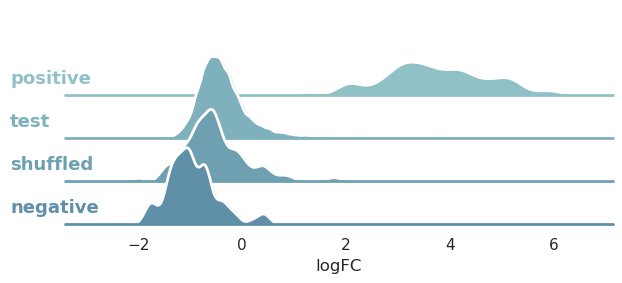

In [59]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
fig_dir = "/data/cephfs-2/unmirrored/groups/kircher/MPRA/CaptureCMPRA/results/manuscript_figures/minP/"
ridge_plot(minp, "logFC", "label")
#plt.tight_layout()
plt.savefig(fig_dir + "ridge_plot_minP.pdf", format="pdf")

## Histogram of enhancers per promoter

Text(0, 0.5, 'Number of promoters')

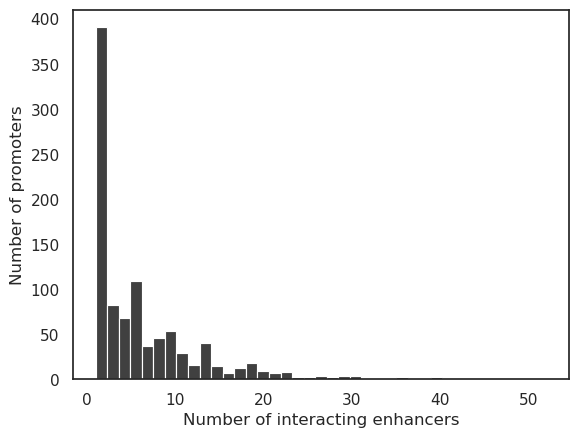

In [60]:
# check how many OEs per promoter we have
counts = df.group_by("promoter").agg(pl.count("OE"))

# plot the counts
sns.histplot(counts.to_pandas(), x="OE", color="black")
plt.xlabel("Number of interacting enhancers")
plt.ylabel("Number of promoters")

## Direct plotting of enhancer activity for specific promoter

<Axes: >

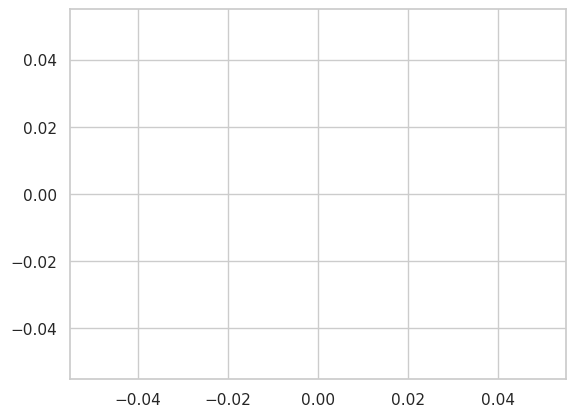

In [61]:
# just plotting the values of the minP to the CMPRA logFC for a single promoter
sns.set_style(style='whitegrid')
promoter = "chr14-24141981-24142199"
df_promoter = df.filter(pl.col("promoter") == promoter).sort("logFC")

sns.scatterplot(data = df_promoter.to_pandas(), x="logFC", y="minp_logFC")

## Scatterplot of all values, minP vs CMPRA logFC

<Axes: xlabel='logFC', ylabel='minp_logFC'>

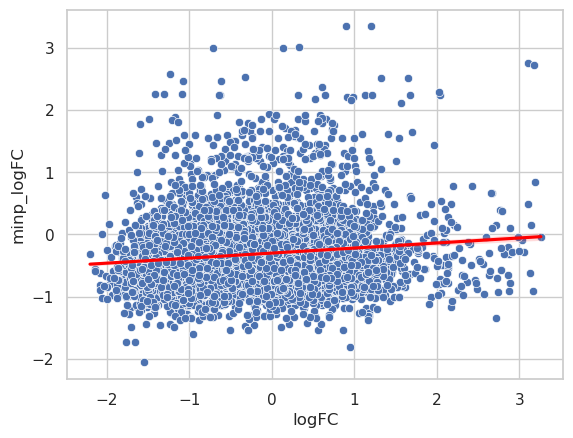

In [62]:
# repeat this plot for all promoters
sns.scatterplot(data = df.to_pandas(), x="logFC", y="minp_logFC")
sns.regplot(data=df.to_pandas(), x="logFC", y="minp_logFC", scatter=False, color='red')

In [18]:
df.filter((pl.col("minp_logFC") < pl.col("logFC")+0.5) & (pl.col("minp_logFC") > pl.col("logFC")-0.5)).head()


logFC,minp_logFC,adj.P.Val,minp_padj,label,OE,promoter,dist,prom_length,OE_length
f64,f64,f64,f64,str,str,str,f64,i32,i32
-0.370148,-0.839352,0.031683,2.2192e-45,"""target - other""","""chr17-58401197-58401425""","""chr17-58417524-58417783""",16342.5,259,228
-0.724263,-0.71418,0.008112,1.3387e-68,"""target - other""","""chr14-23935448-23935655""","""chr14-24141981-24142199""",206538.5,218,207
0.743424,0.568919,1.6757e-9,1.7081e-44,"""target - other""","""chr1-24075968-24076182""","""chr1-24642398-24643304""",566776.0,906,214
-0.304731,0.040356,0.011295,0.335,"""positive - other""","""chr16-71882415-71882635""","""chr16-71894774-71895129""",12426.5,355,220
-1.137621,-0.808284,1.5126e-21,3.5966e-39,"""target - other""","""chr13-23565605-23565805""","""chr13-23569910-23570163""",4331.5,253,200


In [19]:

df.with_columns(count = pl.count("OE").over("label")).unique("label").mean()

logFC,minp_logFC,adj.P.Val,minp_padj,label,OE,promoter,dist,prom_length,OE_length,count
f64,f64,f64,f64,str,str,str,f64,f64,f64,f64
-1.066999,-0.216796,0.000001,0.074644,null,null,null,342999.5,270.0,232.5,2827.5


## Visualizing correlation between activity of minP and CMPRA per promoter

Text(0.5, 0, 'Correlation')

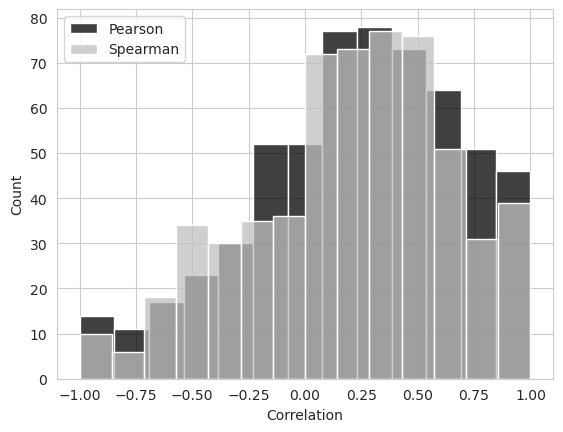

In [24]:
# Calculating the correlation between the minP logFC and the CMPRA logFC
correlation = df.group_by("promoter").agg(
	pearson_corr = pl.corr("logFC", "minp_logFC", method="pearson"), 
	spearman_corr = pl.corr("logFC", "minp_logFC", method="spearman"),
	count = pl.count("logFC")).filter(pl.col("count") > 2)

# Plotting the distribution of correlations
sns.histplot(correlation.to_pandas(), x="pearson_corr", color="black", label="Pearson")
sns.histplot(correlation.to_pandas(), x="spearman_corr", color="silver", label="Spearman")
plt.legend()
plt.xlabel("Correlation")

In [25]:
correlation.head()

promoter,pearson_corr,spearman_corr,count
str,f64,f64,u32
"""chr14-45134696-45134896--""",-0.562839,-0.7,5
"""chr10-60389553-60390035--""",0.598374,0.466667,10
"""chr11-126211600-126211960--""",0.381443,0.404762,8
"""chr6-63635384-63636290-+""",-0.396746,-0.305495,14
"""chr17-58417524-58417783--""",0.280399,0.268145,31


## Q-Q plot of entire data

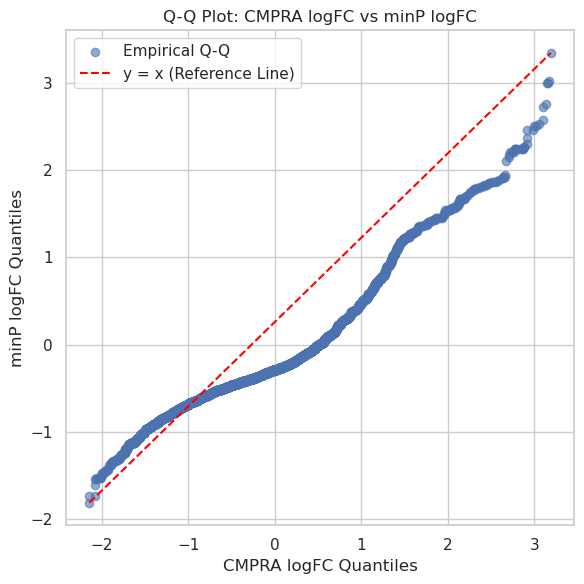

In [101]:
# Q-Q plot code from chat gpt
sns.set_style(style='whitegrid')

# Extract the two distributions
x = df.to_pandas()["logFC"] #.dropna()  # Drop NaN values to avoid issues
y = df.to_pandas()["minp_logFC"]# .dropna()

# Ensure both distributions have the same length by trimming the larger one
min_len = min(len(x), len(y))
x = np.sort(x) #[:min_len])
y = np.sort(y) #[:min_len])

# Compute quantiles
quantiles = np.linspace(0, 1, min_len, endpoint=False)[1:]  # Avoid 0 and 1 quantiles
x_quantiles = np.quantile(x, quantiles)
y_quantiles = np.quantile(y, quantiles)

# Create Q-Q plot
plt.figure(figsize=(6, 6))
plt.scatter(x_quantiles, y_quantiles, alpha=0.6, label="Empirical Q-Q")
plt.plot([x_quantiles.min(), x_quantiles.max()], 
         [y_quantiles.min(), y_quantiles.max()], 
         color='red', linestyle='--', label="y = x (Reference Line)")
plt.xlabel("CMPRA logFC Quantiles")
plt.ylabel("minP logFC Quantiles")
plt.title("Q-Q Plot: CMPRA logFC vs minP logFC")
plt.legend()
#plt.grid()
plt.tight_layout()
# Show the plot
plt.savefig(fig_dir + "qq_plot_minP.pdf", format="pdf")

## Enhancers per promoter

Text(0, 0.5, 'Number of promoters')

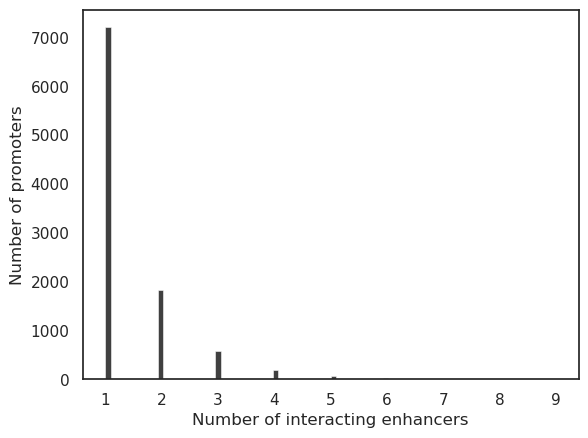

In [15]:
# check how many promoters per enhancer we have
counts = df.groupby("OE").agg(pl.count("promoter"))

# plot the counts
sns.histplot(counts, x="promoter", color="black")
plt.xlabel("Number of interacting enhancers")
plt.ylabel("Number of promoters")

## Get single enhancers from CMPRA

In [65]:
cmpra_df = cmpra.with_columns(
	target_genes = pl.concat_str(pl.col("target_gene_left"), pl.col("target_gene_right"),
	separator=",").str.replace("unlabeled,", "").str.replace(",unlabeled", ""))
cmpra_df = cmpra_df.select(pl.exclude("target_gene_left", "target_gene_right"))
cmpra_df = cmpra_df.filter(pl.col("target_genes").str.contains(",").not_())

cmpra_df = cmpra_df.filter(
		(pl.col("label") != "other - other") & (pl.col("label").str.contains("other"))
	).with_columns(pl.when(pl.col("targeted_left") != "unlabeled").then(pl.col("left_bin"))
				   .when(pl.col("targeted_right") != "unlabeled").then(pl.col("right_bin")).alias("promoter"), 
				   pl.when(pl.col("targeted_left") != "unlabeled").then(pl.col("right_bin"))
				   .when(pl.col("targeted_right") != "unlabeled").then(pl.col("left_bin")).alias("OE")
	)

print(cmpra.filter(pl.col("right_bin").str.contains("null")) \
	.filter(pl.col("targeted_left") == "unlabeled") \
	.filter(pl.col("logFC") > 0.5) \
	.join(minp_tested, left_on="left_bin", right_on="name") \
	.select(pl.corr("logFC", "minp_logFC", method="spearman")))

print(cmpra
	.join(minp_tested, left_on="left_bin", right_on="name") \
	.select(pl.corr("logFC", "minp_logFC", method="spearman")))

cmpra.filter(pl.col("right_bin").str.contains("null")) \
	.filter(pl.col("targeted_left") == "unlabeled") \
	.filter(pl.col("logFC") > 0.5) \
	.join(minp_tested, left_on="left_bin", right_on="name").select("logFC", "minp_logFC").head()

minp.filter(pl.col("label") != "test").filter(pl.col("label") != "shuffled") \
	.with_columns(pl.col("oligo_name").str.replace("_Reversed:", "").str.split("_").list.get(4).str.replace(":", "-")).select(
	minp_logFC = pl.col("logFC"),
	minp_padj = pl.col("adj.P.Val"),
	name = pl.col("oligo_name")
).join(cmpra, left_on="name", right_on="right_bin")

# sns.scatterplot(cmpra.filter(pl.col("right_bin").str.contains("null")) \
# 	.filter(pl.col("targeted_left") == "unlabeled") \
# 	.join(minp_tested, left_on="left_bin", right_on="name").select("logFC", "minp_logFC").to_pandas(), x="logFC", y="minp_logFC")

# prom_only_logfcs = prom_only_logfcs.group_by("target_genes").mean()
# relative_activity = cmpra_df.join(prom_only_logfcs, on="target_genes")
# # relative_activity = relative_activity.with_columns(
# # 	std = np.sqrt(((pl.col("logFC")- pl.col("promoter_only"))).over("target_genes").pow(2).sum()/(pl.col("logFC").count().over("target_genes")-1)))
# relative_activity = relative_activity.with_columns(
# 	std = pl.col("logFC").std().over("target_genes"))

shape: (1, 1)
┌───────────┐
│ logFC     │
│ ---       │
│ f64       │
╞═══════════╡
│ -0.354545 │
└───────────┘
shape: (1, 1)
┌──────────┐
│ logFC    │
│ ---      │
│ f64      │
╞══════════╡
│ 0.147438 │
└──────────┘


minp_logFC,minp_padj,name,logFC,adj.P.Val,P.Value,left_bin,nr_reads,nr_seqs,any_tss,screen_left,screen_right,targeted_left,targeted_right,target_gene_left,target_gene_right,label,interaction,dist,target_genes,effect,promoter,OE,promoter_only,std,z_score
f64,f64,str,f64,f64,f64,str,i64,i64,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,f64,f64,f64


## Overlap of pos en neg controls

In [ ]:
controls = pl.read_csv("cmpra_control_overlap.tsv", separator="\t", has_header=False, new_columns=["bin", "label"])
cmpra.join(controls, left_on="right_bin", right_on="bin")


## Calculate normalized activity

In [15]:
cmpra_df = cmpra.with_columns(
	target_genes = pl.concat_str(pl.col("target_gene_left"), pl.col("target_gene_right"),
	separator=",").str.replace("unlabeled,", "").str.replace(",unlabeled", ""))
cmpra_df = cmpra_df.select(pl.exclude("target_gene_left", "target_gene_right"))
cmpra_df = cmpra_df.filter(pl.col("target_genes").str.contains(",").not_())

cmpra_df = cmpra_df.filter(
		(pl.col("label") != "other - other") & (pl.col("label").str.contains("other"))
	).with_columns(pl.when(pl.col("targeted_left") != "unlabeled").then(pl.col("left_bin"))
				   .when(pl.col("targeted_right") != "unlabeled").then(pl.col("right_bin")).alias("promoter"), 
				   pl.when(pl.col("targeted_left") != "unlabeled").then(pl.col("right_bin"))
				   .when(pl.col("targeted_right") != "unlabeled").then(pl.col("left_bin")).alias("OE")
	)

prom_only_logfcs = cmpra_df.filter(
	pl.col("right_bin").str.contains("null")).select("promoter", promoter_only = "logFC")
prom_only_logfcs = prom_only_logfcs.group_by("promoter").mean()
relative_activity = cmpra_df.join(prom_only_logfcs, on="promoter")
# relative_activity = relative_activity.with_columns(
# 	std = np.sqrt(((pl.col("logFC")- pl.col("promoter_only"))).pow(2).sum().over("promoter")/(pl.col("logFC").count().over("promoter")-1)))
relative_activity = relative_activity.with_columns(
	std = pl.col("logFC").std().over("promoter"))

In [16]:
cmpra_norm_activity = relative_activity.select("target_genes", "logFC", "promoter_only", "std", "OE", "label", "promoter", "adj.P.Val",
	norm_logFC = (pl.col("logFC") - pl.col("promoter_only"))/pl.col("std")) \
	.with_columns(pl.when(pl.col("logFC") > pl.col("promoter_only") + 2*pl.col("std"))
	.then(pl.lit("upregulating"))
	.when(pl.col("logFC") < pl.col("promoter_only") - 2*pl.col("std"))
	.then(pl.lit("downregulating"))
	.otherwise(pl.lit("no effect")).alias("effect"))


In [17]:
minp_shuff_med = minp.filter(pl.col("label") == "shuffled").select(pl.col("logFC").median()).to_numpy()[0][0]
minp_shuff_std = minp.filter(pl.col("label") == "shuffled").select(pl.col("logFC").std()).to_numpy()[0][0]
print(minp_shuff_med, minp_shuff_std)
minp_norm_activity = minp_tested.with_columns(norm_minp_logFC = (pl.col("minp_logFC") - minp_shuff_med)/minp_shuff_std)

-0.596084955679498 0.6082064494203121


In [18]:
joined_norm = cmpra.with_columns(norm_logFC = pl.col("z_score")).join(minp_norm_activity, left_on="OE", right_on="name")
# Filter again on distance
joined_norm = joined_norm.join(df_filt.select("promoter", "OE", "dist", cs.matches("length")), on=["promoter", "OE"])
print(joined_norm.height)
# Ensure that we only have those promoters with > 2 enhancers
#joined_norm = joined_norm.filter(pl.count("OE")0)
#joined_norm = joined_norm.filter(pl.col("norm_minp_logFC") < 2)

# minmax normalize
# joined_norm = joined_norm.with_columns(
# 	norm_logFC = (pl.col("norm_logFC") - pl.col("norm_logFC").min())/(pl.col("norm_logFC").max() - pl.col("norm_logFC").min()),
# 	norm_minp_logFC = (pl.col("norm_minp_logFC") - pl.col("norm_minp_logFC").min())/(pl.col("norm_minp_logFC").max() - pl.col("norm_minp_logFC").min())
# )

print(joined_norm.height)

5963
5963


<Axes: xlabel='norm_logFC', ylabel='norm_minp_logFC'>

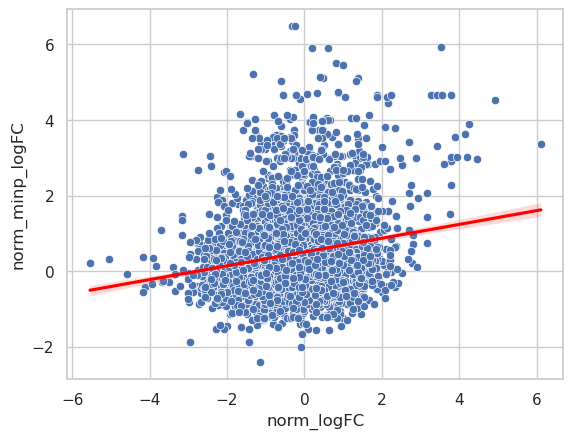

In [72]:
sns.scatterplot(data=joined_norm.to_pandas(), x="norm_logFC", y="norm_minp_logFC")
sns.regplot(data=joined_norm.to_pandas(), x="norm_logFC", y="norm_minp_logFC", scatter=False, color='red')

<Axes: xlabel='norm_logFC', ylabel='norm_minp_logFC'>

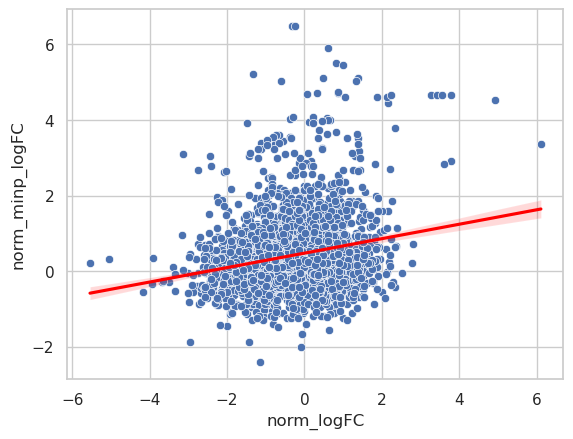

In [73]:
sns.scatterplot(data=joined_norm.filter(pl.col("adj.P.Val") < 0.0005).to_pandas(), x="norm_logFC", y="norm_minp_logFC")
sns.regplot(data=joined_norm.filter(pl.col("adj.P.Val") < 0.0005).to_pandas(), x="norm_logFC", y="norm_minp_logFC", scatter=False, color='red')

<Axes: xlabel='norm_logFC', ylabel='norm_minp_logFC'>

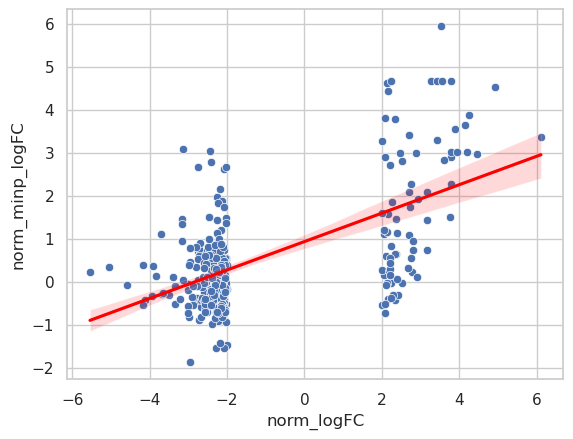

In [74]:
sns.scatterplot(data=joined_norm.filter(np.abs(pl.col("norm_logFC")) > 2).to_pandas(), x="norm_logFC", y="norm_minp_logFC")
sns.regplot(data=joined_norm.filter(np.abs(pl.col("norm_logFC")) > 2).to_pandas(), x="norm_logFC", y="norm_minp_logFC", scatter=False, color='red')

In [27]:
joined_norm.select(pl.corr("logFC", "minp_logFC"), pl.corr("norm_logFC", "norm_minp_logFC"))

logFC,norm_logFC
f64,f64
0.127154,0.201382


In [76]:
joined_norm.filter((pl.col("norm_minp_logFC") < pl.col("norm_logFC")+0.5) & (pl.col("norm_minp_logFC") > pl.col("norm_logFC")-0.5)).mean()

logFC,adj.P.Val,P.Value,left_bin,right_bin,nr_reads,nr_seqs,any_tss,screen_left,screen_right,targeted_left,targeted_right,target_gene_left,target_gene_right,label,interaction,dist,target_genes,effect,promoter,OE,promoter_only,std,z_score,norm_logFC,minp_logFC,minp_padj,norm_minp_logFC,dist_right,prom_length,OE_length
f64,f64,f64,str,str,f64,f64,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.080104,0.117774,0.108681,null,null,10.861798,2.140616,null,null,null,null,null,null,null,null,null,148665.204285,null,null,null,null,-0.125335,0.539955,0.106504,0.106504,-0.51111,0.0304,0.139714,148665.204285,367.672299,230.645745


In [77]:
joined_norm.mean()

logFC,adj.P.Val,P.Value,left_bin,right_bin,nr_reads,nr_seqs,any_tss,screen_left,screen_right,targeted_left,targeted_right,target_gene_left,target_gene_right,label,interaction,dist,target_genes,effect,promoter,OE,promoter_only,std,z_score,norm_logFC,minp_logFC,minp_padj,norm_minp_logFC,dist_right,prom_length,OE_length
f64,f64,f64,str,str,f64,f64,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.268209,0.111907,0.10301,null,null,10.7622,2.139024,null,null,null,null,null,null,null,null,null,148598.539745,null,null,null,null,-0.056841,inf,-0.322458,-0.322458,-0.322115,0.037328,0.450455,148598.539745,359.664934,231.289787


<Axes: xlabel='norm_minp_logFC', ylabel='norm_logFC'>

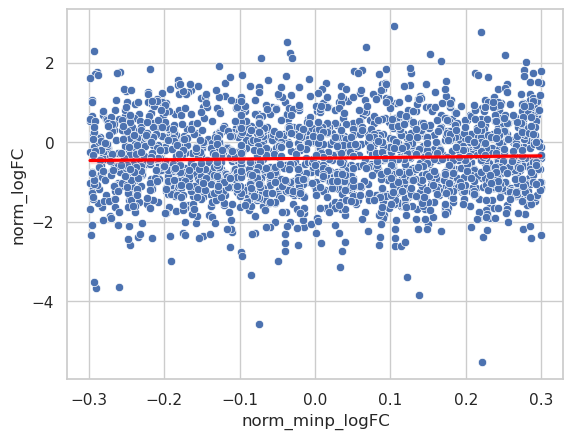

In [78]:
# Focussing on those close to 0
sns.scatterplot(data=joined_norm.filter((pl.col("norm_minp_logFC") < 0.3) & (pl.col("norm_minp_logFC") > -0.3)).to_pandas(), x="norm_minp_logFC", y="norm_logFC")
sns.regplot(data=joined_norm.filter((pl.col("norm_minp_logFC") < 0.3) & (pl.col("norm_minp_logFC") > -0.3)).to_pandas(), x="norm_minp_logFC", y="norm_logFC", scatter=False, color='red')

In [79]:
# Let's investigate the outliers
joined_norm.filter((pl.col("norm_logFC") < 0.5) & (pl.col("norm_logFC") > -0.5)).filter(pl.col("norm_minp_logFC") > 20)
# first one: nothing interesting.
# Second one: known enhancer EH38E3660966

logFC,adj.P.Val,P.Value,left_bin,right_bin,nr_reads,nr_seqs,any_tss,screen_left,screen_right,targeted_left,targeted_right,target_gene_left,target_gene_right,label,interaction,dist,target_genes,effect,promoter,OE,promoter_only,std,z_score,norm_logFC,minp_logFC,minp_padj,norm_minp_logFC,dist_right,prom_length,OE_length
f64,f64,f64,str,str,i64,i64,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,i32,i32


In [83]:
# Let's investigate the outliers the other way around
joined_norm.filter((pl.col("norm_minp_logFC") < 0.5) & (pl.col("norm_minp_logFC") > -0.5)).filter(pl.col("norm_logFC") > 2.5)


logFC,adj.P.Val,P.Value,left_bin,right_bin,nr_reads,nr_seqs,any_tss,screen_left,screen_right,targeted_left,targeted_right,target_gene_left,target_gene_right,label,interaction,dist,target_genes,effect,promoter,OE,promoter_only,std,z_score,norm_logFC,minp_logFC,minp_padj,norm_minp_logFC,dist_right,prom_length,OE_length
f64,f64,f64,str,str,i64,i64,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,i32,i32
0.997079,7.8390e-7,2.7842e-7,"""chr14-35113606-35113837-.""","""chr14-35404489-35405088--""",7,1,"""yes""",null,"""PLS,CTCF-bound,pELS,CTCF-bound""","""unlabeled""","""target""","""unlabeled""","""NFKBIA""","""target - other""","""PLS - ELS""",291067.0,"""NFKBIA""","""upregulating""","""chr14-35404489-35405088--""","""chr14-35113606-35113837-.""",0.171183,0.297587,2.775309,2.775309,-0.462349,1.1321e-11,0.219885,291067.0,599,231
-0.748132,0.009526,0.006435,"""chr12-18738365-18738736--""","""chr12-18982610-18982843-.""",5,1,"""no""",null,"""dELS""","""negativecontrol""","""unlabeled""","""PLCZ1""","""unlabeled""","""negative - other""",null,244176.0,"""PLCZ1""","""upregulating""","""chr12-18738365-18738736--""","""chr12-18982610-18982843-.""",-1.543419,0.272408,2.919472,2.919472,-0.532143,8.4455e-15,0.105131,244176.0,371,233
2.116057,8.6849e-15,7.2028e-16,"""chr14-39175045-39175375-+""","""chr14-39378127-39378347-.""",6,2,"""yes""","""PLS,CTCF-bound""",null,"""positivecontrol""","""unlabeled""","""PNN""","""unlabeled""","""positive - other""",null,203027.0,"""PNN""","""upregulating""","""chr14-39175045-39175375-+""","""chr14-39378127-39378347-.""",0.984115,0.450697,2.511538,2.511538,-0.618404,2.9583e-28,-0.036697,203027.0,330,220
-0.068911,0.738503,0.706183,"""chr1-234610383-234611040--""","""chr1-234900455-234900666-.""",6,1,"""no""","""pELS,CTCF-bound,PLS,CTCF-bound""","""dELS""","""target""","""unlabeled""","""IRF2BP2""","""unlabeled""","""target - other""","""PLS - ELS""",289849.0,"""IRF2BP2""","""upregulating""","""chr1-234610383-234611040--""","""chr1-234900455-234900666-.""",-1.286722,0.457224,2.663488,2.663488,-0.403134,6.5123e-12,0.317245,289849.0,657,211


<Axes: xlabel='norm_logFC', ylabel='Count'>

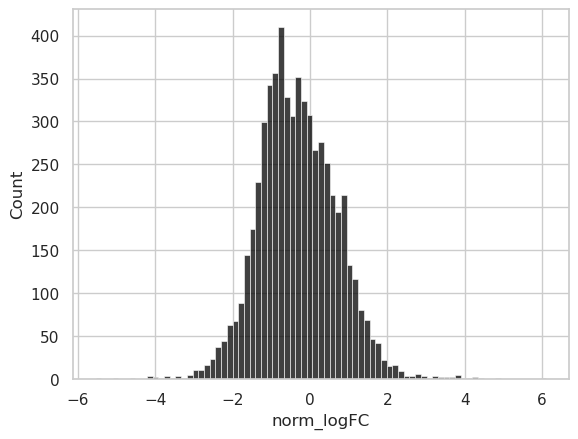

In [84]:
sns.histplot(joined_norm, x="norm_logFC", color="black", label="CMPRA")

Text(0.5, 0, 'Correlation')

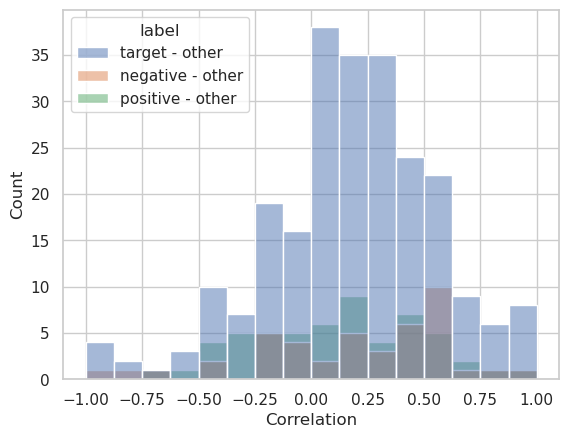

In [86]:
# Calculating the correlation between the minP norm_logFC and the CMPRA norm_logFC
correlation = joined_norm.group_by("target_genes").agg(
	pl.col("label").first(),
	pearson_corr = pl.corr("norm_logFC", "norm_minp_logFC", method="pearson"), 
	spearman_corr = pl.corr("norm_logFC", "norm_minp_logFC", method="spearman"),
	count = pl.count("norm_logFC")).filter(pl.col("count") > 2)

# Plotting the distribution of correlations
#sns.histplot(correlation, x="pearson_corr", color="black", label="Pearson", hue="label")
sns.histplot(correlation, x="spearman_corr",  hue="label")
plt.xlabel("Correlation")

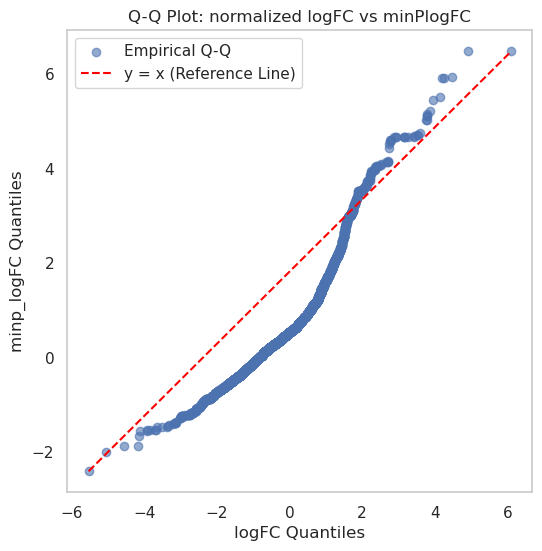

In [87]:
# Q-Q plot code from chat gpt


# Extract the two distributions
x = joined_norm.to_pandas()["norm_logFC"] #.dropna()  # Drop NaN values to avoid issues
y = joined_norm.to_pandas()["norm_minp_logFC"]# .dropna()

# Ensure both distributions have the same length by trimming the larger one
min_len = min(len(x), len(y))
x = np.sort(x) #[:min_len])
y = np.sort(y) #[:min_len])

# Compute quantiles
quantiles = np.linspace(0, 1, min_len, endpoint=False)[1:]  # Avoid 0 and 1 quantiles
x_quantiles = x #np.quantile(x, quantiles)
y_quantiles = y #np.quantile(y, quantiles)

# Create Q-Q plot
plt.figure(figsize=(6, 6))
plt.scatter(x_quantiles, y_quantiles, alpha=0.6, label="Empirical Q-Q")
plt.plot([x_quantiles.min(), x_quantiles.max()], 
         [y_quantiles.min(), y_quantiles.max()], 
         color='red', linestyle='--', label="y = x (Reference Line)")
plt.xlabel("logFC Quantiles")
plt.ylabel("minp_logFC Quantiles")
plt.title("Q-Q Plot: normalized logFC vs minPlogFC")
plt.legend()
plt.grid()

# Show the plot
plt.show()

## Jaccards of active/inactive sets

In [28]:
print("total number of sequences: ", joined_norm.height)
print("CMPRA enhancers: ", joined_norm.filter(pl.col("norm_logFC") > 2).height)
print("CMPRA silencers: ", joined_norm.filter(pl.col("norm_logFC") < -2).height)
print("minP enhancers: ", joined_norm.filter(pl.col("norm_minp_logFC") > 2).height)
print("minP silencers: ", joined_norm.filter(pl.col("norm_minp_logFC") < -2).height)
print("CMPRA enhancer, minP enhancer: ", joined_norm.filter(pl.col("norm_logFC") > 2).filter(pl.col("norm_minp_logFC") > 2).height)
print("CMPRA enhancer, minP no effect: ", joined_norm.filter(pl.col("norm_logFC") > 2).filter(np.abs(pl.col("norm_minp_logFC")) < 2).height)
print("CMPRA enhancer, minP silencer: ", joined_norm.filter(pl.col("norm_logFC") > 2).filter(pl.col("norm_minp_logFC") < -2).height)
print("CMPRA silencer, minP enhancer: ", joined_norm.filter(pl.col("norm_logFC") < -2).filter(pl.col("norm_minp_logFC") > 2).height)
print("CMPRA silencer, minP no effect: ", joined_norm.filter(pl.col("norm_logFC") < -2).filter(np.abs(pl.col("norm_minp_logFC")) < 2).height)
print("CMPRA silencer, minP silencer: ", joined_norm.filter(pl.col("norm_logFC") < -2).filter(pl.col("norm_minp_logFC") < -2).height)
print("CMPRA no effect, minP enhancer: ", joined_norm.filter(np.abs(pl.col("norm_logFC")) < 2).filter(pl.col("norm_minp_logFC") > 2).height)
print("CMPRA no effect, minP silencer: ", joined_norm.filter(np.abs(pl.col("norm_logFC")) < 2).filter(pl.col("norm_minp_logFC") < -2).height)


total number of sequences:  5963
CMPRA enhancers:  77
CMPRA silencers:  226
minP enhancers:  354
minP silencers:  1
CMPRA enhancer, minP enhancer:  33
CMPRA enhancer, minP no effect:  44
CMPRA enhancer, minP silencer:  0
CMPRA silencer, minP enhancer:  7
CMPRA silencer, minP no effect:  219
CMPRA silencer, minP silencer:  0
CMPRA no effect, minP enhancer:  314
CMPRA no effect, minP silencer:  1


## multi occuring enhancers

In [124]:
multi_occuring_enhancers = joined_norm.filter(pl.col("promoter").len().over("OE") > 4).filter(np.abs(pl.col("logFC")).std().over("OE") < 0.4)


<Axes: xlabel='logFC', ylabel='minp_logFC'>

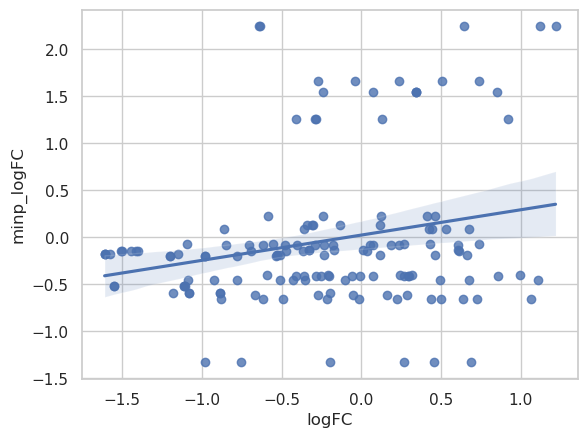

In [126]:
sns.regplot(data=multi_occuring_enhancers.to_pandas(), x="logFC", y="minp_logFC")

## PSI score

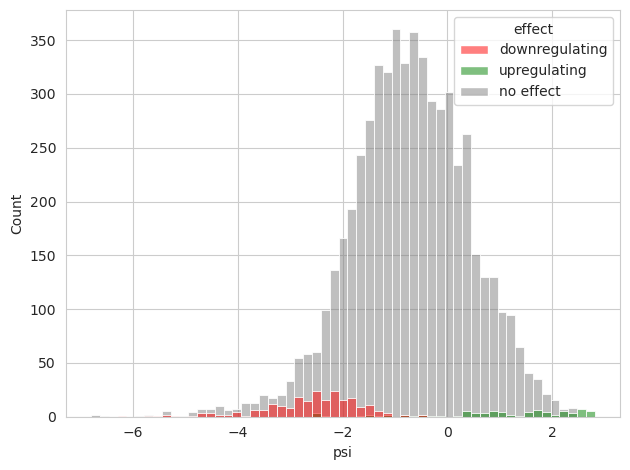

In [19]:
psi_df = joined_norm.with_columns(psi = pl.col("norm_logFC") - pl.col("norm_minp_logFC"))
sns.histplot(psi_df, x="psi", hue="effect", multiple="layer", hue_order=["downregulating", "upregulating", "no effect"], 
			 palette={"downregulating": "red", "upregulating": "green", "no effect": "grey"}, alpha=0.5)

plt.tight_layout()
plt.savefig(fig_dir + "psi_plot_minP.pdf", format="pdf")

In [20]:
psi_df.filter(pl.col("psi") > 0).group_by("effect").count()

effect,count
str,u32
"""upregulating""",60
"""no effect""",1490


In [21]:
psi_df.filter(pl.col("psi") < 0).group_by("effect").count()

effect,count
str,u32
"""downregulating""",226
"""upregulating""",17
"""no effect""",4170


In [22]:
print(686/(686+26))
print(228/(228+14))


0.9634831460674157
0.9421487603305785


1.1874702839441647 -2.7748238304644293


psi_percentile,count
str,u32
"""higher_cmpra""",210
"""lower_cmpra""",168
"""similar""",5585


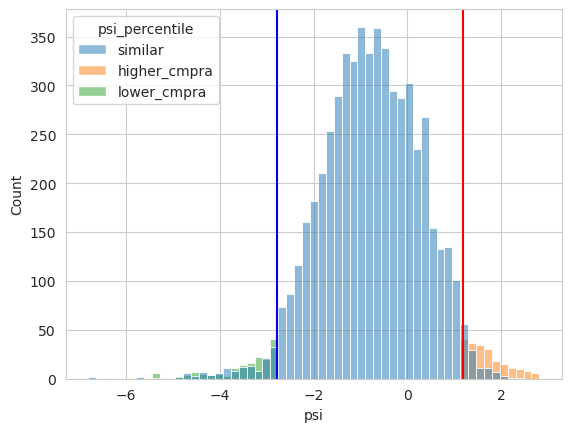

In [28]:
psi_df = joined_norm.with_columns(psi = pl.col("norm_logFC") - pl.col("norm_minp_logFC"))
upper = psi_df.select(pl.col("psi").quantile(0.95)).to_numpy()[0][0]
lower = psi_df.select(pl.col("psi").quantile(0.05)).to_numpy()[0][0]

similar = psi_df.filter(pl.col("psi") > lower).filter(pl.col("psi") < upper)
higher_cmpra = psi_df.filter(pl.col("psi") > upper).filter(pl.col("z_score") > 1)
lower_cmpra = psi_df.filter(pl.col("psi") < lower).filter(pl.col("z_score") < -1)
psi_df = psi_df.with_columns(
	pl.when((pl.col("psi") > upper) & (pl.col("z_score") > 1)).then(pl.lit("higher_cmpra"))
	.when((pl.col("psi") < lower) & (pl.col("z_score") < -1)).then(pl.lit("lower_cmpra"))
	.otherwise(pl.lit("similar")).alias("psi_percentile")
)

sns.histplot(psi_df, x="psi", hue="psi_percentile")
plt.axvline(upper, color="red")
plt.axvline(lower, color="blue")
print(upper, lower)

psi_df.group_by("psi_percentile").count()

In [29]:
higher_cmpra = higher_cmpra.with_columns(pl.when(pl.col("targeted_left") == "unlabeled").then(pl.col("screen_left")).otherwise(pl.col("screen_right")).alias("SCREEN label"))
# Simplify the labels (when it contains "PLS", it is a promoter, when it contains "ELS", it is an enhancer)
higher_cmpra.select("SCREEN label").filter(pl.col("SCREEN label").str.contains("LS")).height

56

In [39]:
psi_df.group_by("psi_percentile").agg(avg_zscore = pl.col("z_score").mean())

psi_percentile,avg_zscore
str,f64
"""higher_cmpra""",1.35086
"""similar""",-0.362956
"""lower_cmpra""",-1.266391


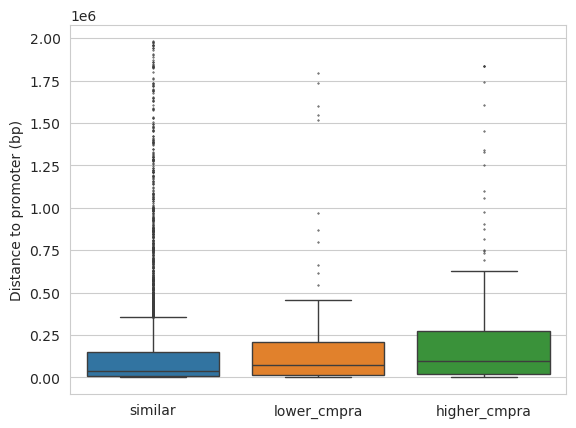

In [18]:
sns.set_style(style='whitegrid')
sns.boxplot(data=psi_df.sort("psi_percentile", descending=True).to_pandas(), x="psi_percentile", y="dist", hue="psi_percentile", fliersize=0.5, legend=False)
plt.xlabel("")
plt.ylabel("Distance to promoter (bp)")
plt.savefig(fig_dir + "psi_distance_boxplot.png")

In [20]:
print("similar vs lower cmpra",stats.ttest_ind(
	psi_df.filter(pl.col("psi_percentile") == "similar").select("dist").to_numpy().flatten(), 
	psi_df.filter(pl.col("psi_percentile") == "lower_cmpra").select("dist").to_numpy().flatten()))

print("similar vs higher cmpra",stats.ttest_ind(
	psi_df.filter(pl.col("psi_percentile") == "similar").select("dist").to_numpy().flatten(), 
	psi_df.filter(pl.col("psi_percentile") == "higher_cmpra").select("dist").to_numpy().flatten()))

print("higher cmpra vs lower_cmpra",stats.ttest_ind(
	psi_df.filter(pl.col("psi_percentile") == "higher_cmpra").select("dist").to_numpy().flatten(), 
	psi_df.filter(pl.col("psi_percentile") == "lower_cmpra").select("dist").to_numpy().flatten()))


similar vs lower cmpra TtestResult(statistic=np.float64(-1.3353612892279283), pvalue=np.float64(0.18181088621168656), df=np.float64(5761.0))
similar vs higher cmpra TtestResult(statistic=np.float64(-4.493563264021215), pvalue=np.float64(7.140093370636259e-06), df=np.float64(5804.0))
higher cmpra vs lower_cmpra TtestResult(statistic=np.float64(1.6941339183271846), pvalue=np.float64(0.0910657301419447), df=np.float64(377.0))


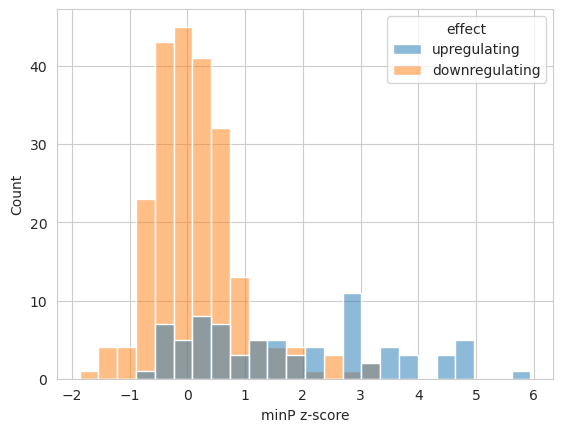

In [24]:
sns.histplot(psi_df.filter(pl.col("effect") != "no effect"), x="norm_minp_logFC", hue="effect")
plt.xlabel("minP z-score")
plt.savefig(fig_dir + "minP_zscore_effect.pdf", format="pdf")

<Axes: xlabel='psi_percentile', ylabel='count'>

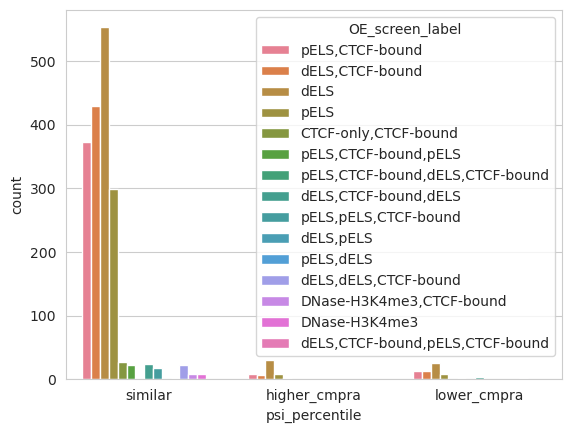

In [75]:
sns.countplot(psi_df.to_pandas(), x="psi_percentile", hue="OE_screen_label")

In [86]:
psi_df.write_csv("/data/cephfs-2/unmirrored/groups/kircher/MPRA/CaptureCMPRA/results/MPRA_analysis/CMPRA5/psi_promoteroa_OA.tsv", separator="\t")

In [81]:
psi_df.filter(pl.col("psi_percentile") == "higher_cmpra").height

210

In [74]:
higher_cmpra.median()

logFC,adj.P.Val,P.Value,left_bin,right_bin,nr_reads,nr_seqs,any_tss,screen_left,screen_right,targeted_left,targeted_right,target_gene_left,target_gene_right,label,interaction,dist,target_genes,effect,promoter,OE,promoter_only,std,z_score,norm_logFC,minp_logFC,minp_padj,norm_minp_logFC,dist_right,prom_length,OE_length,psi
f64,f64,f64,str,str,f64,f64,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.45561,0.000174,0.000091,null,null,6.0,1.0,null,null,null,null,null,null,null,null,null,84638.5,null,null,null,null,-0.256254,0.450697,1.281558,1.281558,-0.782635,6.5908e-36,-0.306722,84638.5,337.5,230.0,1.526655


In [75]:
lower_cmpra.median()

logFC,adj.P.Val,P.Value,left_bin,right_bin,nr_reads,nr_seqs,any_tss,screen_left,screen_right,targeted_left,targeted_right,target_gene_left,target_gene_right,label,interaction,dist,target_genes,effect,promoter,OE,promoter_only,std,z_score,norm_logFC,minp_logFC,minp_padj,norm_minp_logFC,dist_right,prom_length,OE_length,psi
f64,f64,f64,str,str,f64,f64,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.53656,0.00046,0.000256,null,null,7.0,2.0,null,null,null,null,null,null,null,null,null,52164.5,null,null,null,null,0.255937,0.52895,-1.165438,-1.165438,0.749334,1.5851e-55,2.21211,52164.5,354.5,231.0,-3.344639


In [47]:
higher_cmpra.select(pl.corr("norm_logFC", "norm_minp_logFC", method="pearson"))

norm_logFC
f64
0.750686


## Finding promoters similar to minP 

In [95]:

# Load FASTA file
fasta_file = "promoter_sequences.fa"  # Replace with your file
query_sequence = "ACAGTACCGGATTGCCAAGCTGGAAGTCGAGCTTCCATTATATACCCTCTAGTG"  # Replace with your query sequence
max_distance = 10  # Adjust allowed mismatches

# Function to compute minimum Levenshtein distance with shorter sequences
def min_levenshtein_distance(short_seq, long_seq, max_dist):
    min_distance = float("inf")
    # Slide over the longer sequence
    for i in range(len(long_seq) - len(short_seq) + 1):
        substring = long_seq[i : i + len(short_seq)]
        distance = Levenshtein.distance(substring, short_seq)
        if distance < min_distance:
            min_distance = distance
            # Break early if within max distance
            if min_distance <= max_dist:
                break
    return min_distance

# Find matches
matches = []
for record in SeqIO.parse(fasta_file, "fasta"):
    seq = str(record.seq)
    if len(seq) >=20:
        if len(seq) <= len(query_sequence):
            # Compute the minimum Levenshtein distance
            distance = min_levenshtein_distance(seq, query_sequence, max_distance)
            if distance <= max_distance:
                matches.append((record.id, seq, distance))

# Print results
print(len(matches))
for match in matches:
    print(f"Match found: {match[0]}\nSequence: {match[1]}\nLevenshtein Distance: {match[2]}\n")


FileNotFoundError: [Errno 2] No such file or directory: 'promoter_sequences.fa'

## E2G overlaps

In [172]:
e2g = pl.read_csv("../../data/ENCODE_E2G_HepG2/e2g_CMPRA_overlaps.tsv", separator="\t", has_header=False, new_columns=["bin_prom", "bin_OE", "gene", "score"])

In [176]:
prom_e2g = psi_df.join(e2g, left_on="promoter", right_on="bin_prom")
enh_e2g = psi_df.join(e2g, left_on="OE", right_on="bin_OE")

In [181]:
prom_e2g.join(enh_e2g, on="gene").unique("target_genes")

target_genes,logFC,promoter_only,std,OE,label,promoter,norm_logFC,minp_logFC,minp_padj,norm_minp_logFC,dist,prom_length,OE_length,psi,bin_OE,gene,score,target_genes_right,logFC_right,promoter_only_right,std_right,OE_right,label_right,promoter_right,norm_logFC_right,minp_logFC_right,minp_padj_right,norm_minp_logFC_right,dist_right,prom_length_right,OE_length_right,psi_right,bin_prom,score_right
str,f64,f64,f64,str,str,str,f64,f64,f64,f64,f64,i32,i32,f64,str,str,f64,str,f64,f64,f64,str,str,str,f64,f64,f64,f64,f64,i32,i32,f64,str,f64
"""FZD5""",-1.179842,-0.371617,0.528486,"""chr2-207769272-207769509""","""target - other""","""chr2-207769510-207770520""",-1.529323,0.086363,0.284989,1.26182,624.5,1010,237,2.791143,"""chr2-207769272-207769509""","""FZD5|chr2:207769006-207770045""",0.993004,"""FZD5""",-1.179842,-0.371617,0.528486,"""chr2-207769272-207769509""","""target - other""","""chr2-207769510-207770520""",-1.529323,0.086363,0.284989,1.26182,624.5,1010,237,2.791143,"""chr2-207768512-207769271""",0.993004
"""KLF10""",0.010865,-1.221865,0.647137,"""chr8-102808760-102808995""","""target - other""","""chr8-102655354-102655855""",1.904899,-0.026352,0.544988,1.053414,153273.0,501,235,0.851485,"""chr8-102653918-102654128""","""KLF10|chr8:102655505-102656285""",0.978416,"""KLF10""",-0.695645,-1.221865,0.647137,"""chr8-102653918-102654128""","""target - other""","""chr8-102655354-102655855""",0.813151,1.604452,6.9354e-143,4.068707,1581.5,501,210,3.255557,"""chr8-102655354-102655855""",0.978416


## Non overlapping E2G

In [268]:
non_overlap_plac = pl.read_csv("plac_non_overlap.tsv", separator="\t", has_header=False, new_columns=["bin"])
non_overlap_hic = pl.read_csv("hic_non_overlap.tsv", separator="\t", has_header=False, new_columns=["bin"])
non_overlap = pl.concat([non_overlap_plac, non_overlap_hic]).unique("bin")

In [270]:
psi_df.join(non_overlap, left_on="OE", right_on="bin", how="anti").mean()
psi_df.join(non_overlap, left_on="OE", right_on="bin", how="semi").mean()

target_genes,logFC,promoter_only,std,OE,label,promoter,adj.P.Val,norm_logFC,minp_logFC,minp_padj,norm_minp_logFC,dist,prom_length,OE_length,psi
str,f64,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
null,-0.367439,-0.282041,0.580746,null,null,null,0.121196,0.419099,-0.344342,0.035735,0.382242,201897.119469,369.831448,231.271879,0.036856


<Axes: xlabel='psi', ylabel='Count'>

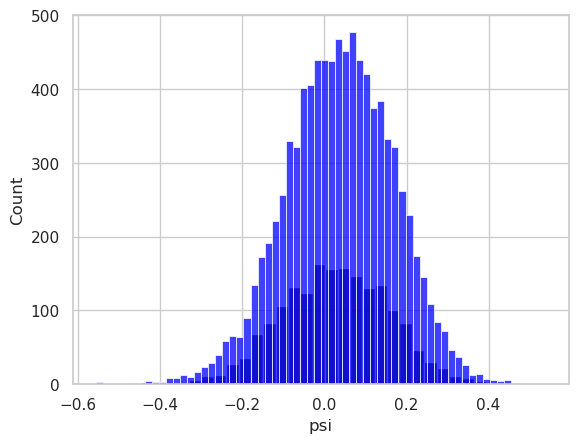

In [271]:
sns.histplot(psi_df.join(non_overlap, left_on="OE", right_on="bin", how="anti"), x="psi", color="black")
sns.histplot(psi_df.join(non_overlap, left_on="OE", right_on="bin", how="semi"), x="psi", color="blue")

In [97]:
enhancers = cmpra.filter(pl.col("right_bin").str.contains("null")) \
	.filter(pl.col("targeted_left") == "unlabeled")
psi_df.join(enhancers, left_on="OE", right_on="left_bin").height

DuplicateError: column with name 'dist_right' already exists

You may want to try:
- renaming the column prior to joining
- using the `suffix` parameter to specify a suffix different to the default one ('_right')

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["logFC", "adj.P.Val", "P.Value", "left_bin", ...]; PROJECT */24 COLUMNS

## Multi enhancers PSI score

In [96]:
sns.histplot(psi_df.join(multi_occuring_enhancers, on="OE"), x="psi", color="blue")

DuplicateError: column with name 'dist_right' already exists

You may want to try:
- renaming the column prior to joining
- using the `suffix` parameter to specify a suffix different to the default one ('_right')

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["logFC", "adj.P.Val", "P.Value", "left_bin", ...]; PROJECT */31 COLUMNS